In [1]:
import os
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import numpy as np
import h5py

drive_path = os.path.join(os.getenv('HOME'), 'work/allen/data/sdk_new_100')

# When downloading 3D connectivity data volumes, what resolution do you want (in microns)?  
# Options are: 10, 25, 50, 100
resolution_um=10

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
manifest_file = os.path.join(drive_path, "manifest.json")

mcc = MouseConnectivityCache(manifest_file=manifest_file, resolution=resolution_um)
ontology = mcc.get_ontology()
# get some info on the isocortex
isocortex = ontology['Isocortex']

# open up a pandas dataframe of all of the experiments
experiments = mcc.get_experiments(dataframe = True, 
                                  injection_structure_ids = [isocortex['id'].values[0]], 
                                  cre = False)
print "%d total experiments" % len(experiments)


/home/kamdh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Function get_ontology is deprecated. Use get_structure_tree instead.
/home/kamdh/anaconda2/lib/python2.7/site-packages/allensdk/core/mouse_connectivity_cache.py:317: VisibleDeprecationWarning: Function get_structures is deprecated. Use get_structure_tree instead.
  return Ontology(self.get_structures(file_name))
/home/kamdh/anaconda2/lib/python2.7/site-packages/allensdk/core/mouse_connectivity_cache.py:317: VisibleDeprecationWarning: Class Ontology is deprecated. Use StructureTree instead.
  return Ontology(self.get_structures(file_name))


126 total experiments


In [2]:
experiments.iloc[0]

gender                                                                   M
id                                                               180435652
injection-coordinates                                   [7820, 4250, 9870]
injection-structures     [{u'abbreviation': u'TEa', u'color': u'15B0B3'...
product-id                                                               5
strain                                                            C57BL/6J
structure-abbrev                                                       ECT
structure-color                                                     0D9F91
structure-id                                                           895
structure-name                                             Ectorhinal area
transgenic-line                                                           
Name: 180435652, dtype: object

In [3]:
def map_to_surface(im, lut, paths, scale = 1, fun = np.max, set_nan = True):
    '''
    maps a gridded voxel image onto the cortical surface
    '''
    scale = float(scale)
    old_dims = im.shape
    new_dims = (1320, 800, 1140) # hard-coded
    for i, dim in enumerate(new_dims):
        assert np.floor(old_dims[i] * scale).astype(int) == dim, \
            "dimension mismatch"
    # deal with scaling through re-indexing
    def remap_coord(c):
        #new_dims = tuple(np.round(np.array(old_dims) * scale).astype(int))
        (I,J,K) = np.unravel_index(c, new_dims)
        I = np.round(I / scale).astype(int)
        J = np.round(J / scale).astype(int)
        K = np.round(K / scale).astype(int)
        return np.ravel_multi_index((I,J,K), old_dims)
    # calculate output array
    output_pd = np.zeros(lut.shape, dtype=im.dtype)    
    # all pixels in surface view with a stream line
    ind = np.where(lut > -1)
    ind = zip(ind[0], ind[1])
    for curr_ind in ind:
        curr_path_id = lut[curr_ind]
        curr_path = paths[curr_path_id, :]
        if scale != 1:
            curr_path_rescale = remap_coord(curr_path)
        else:
            curr_path_rescale = curr_path
        #(I,J,K) = remap_coord(curr_path, old_dims, scale)
        # image along path
        #curr_pd_line = im[I,J,K]
        curr_pd_line = im.flat[curr_path_rescale]
        value = fun(curr_pd_line)
        output_pd[curr_ind] = value
        #if np.any(np.nonzero(curr_pd_line)):
        #    print curr_ind
        #    print curr_path
        #    #print (I,J,K)
        #    print curr_pd_line
        #    print value
        #    break
    if set_nan:
        output_pd[lut == -1] = np.nan
    return output_pd

In [4]:
view_paths_fn = os.path.join(os.getenv('HOME'), 'work/allen/data/TopView/top_view_paths_10.h5')
view_paths_file = h5py.File(view_paths_fn, 'r')
view_lut = view_paths_file['view lookup'][:]
view_paths = view_paths_file['paths'][:]
view_paths_file.close()

In [ ]:

import time
import nrrd

t0 = time.time()

#eid = experiments.iloc[5].id
#row = experiments.iloc[5]
for eid, row in experiments.iterrows():
    print "\nProcessing experiment %d" % eid
    print row
    data_dir = os.path.join(os.getenv('HOME'), "work/allen/data/sdk_new_100/experiment_%d/" % eid)
    
    # get and remap injection data
    print "getting injection density"
    in_d, in_info = mcc.get_injection_density(eid)
    print "mapping to surface"
    in_d_s = map_to_surface(in_d, view_lut, view_paths, scale = resolution_um/10., fun=np.mean)
    in_fn = data_dir + "injection_density_top_view_%d.nrrd" % int(resolution_um)
    print "writing " + in_fn
    nrrd.write(in_fn, in_d_s)
    
    # get and remap projection data
    print "getting projection density"
    pr_d, pr_info = mcc.get_projection_density(eid)
    print "mapping to surface"
    pr_d_s = map_to_surface(pr_d, view_lut, view_paths, scale = resolution_um/10., fun=np.mean)
    pr_fn = data_dir + "projection_density_top_view_%d.nrrd" % int(resolution_um)
    print "writing " + pr_fn
    nrrd.write(pr_fn, pr_d_s)

t1 = time.time()
total = t1-t0
print "%0.1f minutes elapsed" % (total/60.)


Processing experiment 180435652
gender                                                                   M
id                                                               180435652
injection-coordinates                                   [7820, 4250, 9870]
injection-structures     [{u'abbreviation': u'TEa', u'color': u'15B0B3'...
product-id                                                               5
strain                                                            C57BL/6J
structure-abbrev                                                       ECT
structure-color                                                     0D9F91
structure-id                                                           895
structure-name                                             Ectorhinal area
transgenic-line                                                           
Name: 180435652, dtype: object
getting injection density
mapping to surface
writing /home/kamdh/work/allen/data/sdk_new_100/experiment_1804356

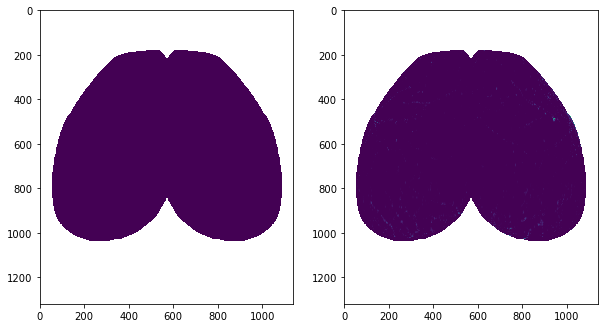

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(121)
h = ax.imshow(in_d_s)
#fig.colorbar(h)

#fig2 = plt.figure(figsize = (10,10))
ax2 = fig.add_subplot(122)
h2 = ax2.imshow(pr_d_s)
#fig2.colorbar(h2)